<a href="https://colab.research.google.com/github/Rinshavip/ISL_TRANSLATOR/blob/main/StoA_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install tensorflow opencv-python matplotlib

In [ ]:
# Imports
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

In [ ]:

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Define paths
base_path = '/content/drive/MyDrive/m2project/ISL_DATASET_Combined'
data_path = f'{base_path}/test'
log_dir = f'{base_path}/logs'
save_dir = f'{base_path}/saved'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Load dataset (grayscale)
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    shuffle=True,
    seed=42
)


Found 21690 files belonging to 36 classes.


In [ ]:

# Get class names and number of classes before applying map
class_names = dataset.class_names
num_classes = len(class_names)
# Access class names using the stored variable
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 36


In [ ]:
# Normalize pixel values
scaled_dataset = dataset.map(lambda x, y: (x / 255.0, y))


In [ ]:
# Correct dataset splitting using TF's built-in functionality
total = len(dataset)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Handles remainder
train = scaled_dataset.take(train_size)
remaining = scaled_dataset.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

# Print the number of batches in each dataset
print(f'Training data: {len(train)} batches')
print(f'Testing data: {len(test)} batches')
print(f'validation data: {len(val)} batches')

Training data: 474 batches
Testing data: 69 batches
validation data: 135 batches


In [ ]:
# Data augmentation
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
# Enhanced training pipeline with shuffling
agmnt_train = train.map(lambda x, y: (augment(x, training=True), y))
agmnt_train = agmnt_train.shuffle(buffer_size=1024) #add shuffling

In [ ]:
# Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,364 (2.39 MB)

 Trainable params: 626,916 (2.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{save_dir}/best_model.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7)
]

In [ ]:
# Train model
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5450 - loss: 1.8790

474/474 ━━━━━━━━━━━━━━━━━━━━ 180s 371ms/step - accuracy: 0.5453 - loss: 1.8775 - val_accuracy: 0.7384 - val_loss: 1.0088 - learning_rate: 5.0000e-04
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9046 - loss: 0.3399

474/474 ━━━━━━━━━━━━━━━━━━━━ 190s 402ms/step - accuracy: 0.9046 - loss: 0.3398 - val_accuracy: 0.9676 - val_loss: 0.1184 - learning_rate: 5.0000e-04
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9597 - loss: 0.1416

474/474 ━━━━━━━━━━━━━━━━━━━━ 192s 404ms/step - accuracy: 0.9597 - loss: 0.1416 - val_accuracy: 0.9792 - val_loss: 0.0732 - learning_rate: 5.0000e-04
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9717 - loss: 0.0928

474/474 ━━━━━━━━━━━━━━━━━━━━ 167s 353ms/step - accuracy: 0.9717 - loss: 0.0928 - val_accuracy: 0.9824 - val_loss: 0.0579 - learning_rate: 5.0000e-04
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9816 - loss: 0.0677

474/474 ━━━━━━━━━━━━━━━━━━━━ 224s 400ms/step - accuracy: 0.9816 - loss: 0.0677 - val_accuracy: 0.9868 - val_loss: 0.0518 - learning_rate: 5.0000e-04
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9894 - loss: 0.0421

474/474 ━━━━━━━━━━━━━━━━━━━━ 169s 357ms/step - accuracy: 0.9894 - loss: 0.0421 - val_accuracy: 0.9863 - val_loss: 0.0486 - learning_rate: 5.0000e-04
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 203s 360ms/step - accuracy: 0.9879 - loss: 0.0405 - val_accuracy: 0.9845 - val_loss: 0.0593 - learning_rate: 5.0000e-04
Epoch 8/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 222s 402ms/step - accuracy: 0.9838 - loss: 0.0490 - val_accuracy: 0.9782 - val_loss: 0.0813 - learning_rate: 5.0000e-04
Epoch 9/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9891 - loss: 0.0357

474/474 ━━━━━━━━━━━━━━━━━━━━ 171s 361ms/step - accuracy: 0.9891 - loss: 0.0357 - val_accuracy: 0.9924 - val_loss: 0.0271 - learning_rate: 3.5000e-04
Epoch 10/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 190s 400ms/step - accuracy: 0.9955 - loss: 0.0139 - val_accuracy: 0.9928 - val_loss: 0.0308 - learning_rate: 3.5000e-04
Epoch 11/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 186s 392ms/step - accuracy: 0.9941 - loss: 0.0157 - val_accuracy: 0.9910 - val_loss: 0.0338 - learning_rate: 3.5000e-04
Epoch 12/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 188s 397ms/step - accuracy: 0.9963 - loss: 0.0140 - val_accuracy: 0.9935 - val_loss: 0.0287 - learning_rate: 2.4500e-04


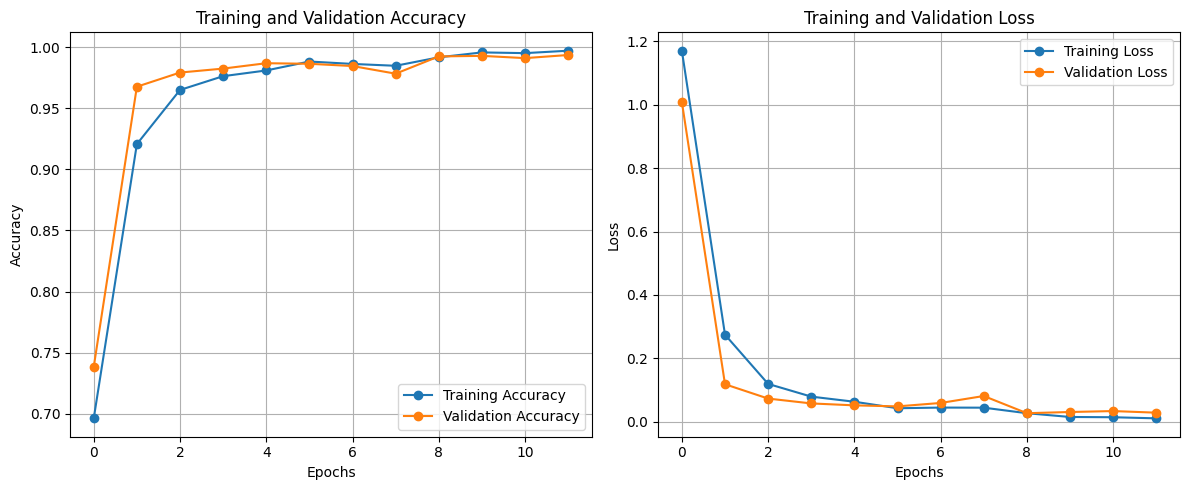

In [ ]:
# Retrieve training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(test)
print(f'\nTest Accuracy: {test_acc * 100:.2f}%, Test Loss: {test_loss:.2f}')

69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - accuracy: 0.9913 - loss: 0.0284

Test Accuracy: 99.00%, Test Loss: 0.04


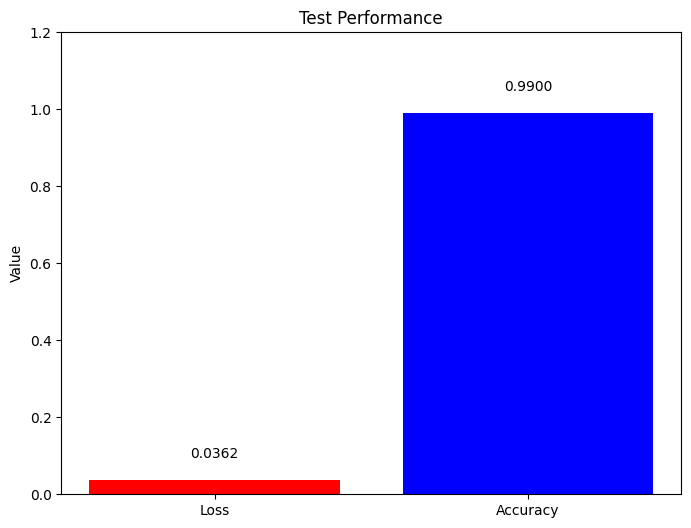

In [ ]:
# Test data (single points)
test_metrics = [test_loss, test_acc]
metric_labels = ['Loss', 'Accuracy']

   # Bar plot for visualization
plt.figure(figsize=(8, 6))
plt.bar(metric_labels, test_metrics, color=['red', 'blue'])
plt.title('Test Performance')
plt.ylabel('Value')
plt.ylim([0, 1.2])  # Adjust y-axis limits if necessary
# Display values on top of bars
for i, v in enumerate(test_metrics):
    plt.text(i, v + 0.05, f'{v:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
# Save model
model.save(f'{save_dir}/ISL_CNN_model.h5')
print(f"Model saved successfully to: {save_dir}/ISL_CNN_model.h5")

Model saved successfully to: /content/drive/MyDrive/m2project/ISL_DATASET_Combined/saved/ISL_CNN_model.h5


In [ ]:
# Predictions and classification report
y_true = []
y_pred = []

for batch in test:
    images, labels = batch
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1

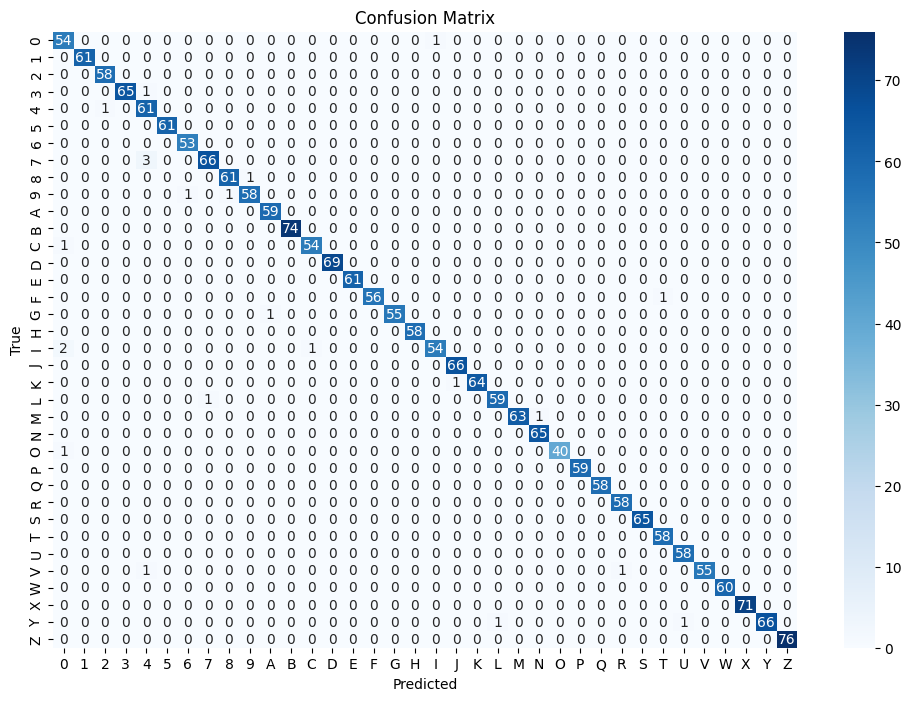

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        55
           1       1.00      1.00      1.00        61
           2       0.98      1.00      0.99        58
           3       1.00      0.98      0.99        66
           4       0.92      0.98      0.95        62
           5       1.00      1.00      1.00        61
           6       0.98      1.00      0.99        53
           7       0.99      0.96      0.97        69
           8       0.98      0.98      0.98        62
           9       0.98      0.97      0.97        60
           A       0.98      1.00      0.99        59
           B       1.00      1.00      1.00        74
           C       0.98      0.98      0.98        55
           D       1.00      1.00      1.00        69
           E       1.00      1.00      1.00        61
           F       1.00      0.98      0.99        57
           G       1.00      0.98      0.99        56
  

In [ ]:
# Save report
with open(f'{save_dir}/classification_report.txt', 'w') as f:
    f.write("Classification Report:\n\n")
    f.write(report)

print(f"Report saved to: {save_dir}/classification_report.txt")


Report saved to: /content/drive/MyDrive/m2project/ISL_DATASET_Combined/saved/classification_report.txt
